# PSF normalization

Let us assume that we have reduced an observation, for which we have determined the PSF by stacking the flux of point-like sources. The PSF we obtain will not be as high S/N as the instrumental PSF that has been determined by the instrument team. Moreover, it is likely to be fattened due to the some small pointing errors. We need to find out what fraction of a point-like flux the PSF we have determined represent. In order to do this, we use the growth curve of the theoretical PSF that has been determine by the instrument team, and compare it to the growth curve we determine from our PSF.

We will use as an example the PACS information from the XMM-LSS.


First, let's load the PSF that was determined by stacking.

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.io import ascii as asciiread
from matplotlib import pyplot as plt
from scipy import interpolate 

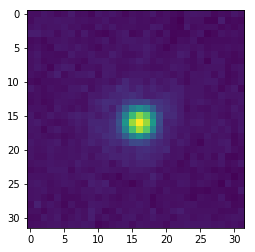

In [2]:
stackhd = fits.open('../data/PACS/XMM-LSS_PACS100_20160728_stacked_psf_100.fits')
psf = stackhd[0].data
hd = stackhd[0].header
plt.imshow(psf)

Now let's build the growthcurve for our PSF.

In [3]:
# find the brightest pixel, it will be our center.
jmax, imax = np.unravel_index(np.argmax(psf), psf.shape)

In [4]:
# build the array of coordinates
x = np.arange(hd['NAXIS1'])
y = np.arange(hd['NAXIS2'])
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
xp = (xv-imax)*np.abs(hd['CDELT1'])*3600.
yp = (yv-jmax)*np.abs(hd['CDELT2'])*3600.
r = np.sqrt(xp**2 + yp**2)

In [5]:
# build the growth curve
radii = np.unique(r)
encircled_flux = np.zeros(radii.shape)
nbpix = np.zeros(radii.shape)
for i, radius in enumerate(radii):
    idj, idi = np.where(r <= radius)
    nbpix[i] =len(idi)
    encircled_flux[i] = np.sum(psf[idj, idi])

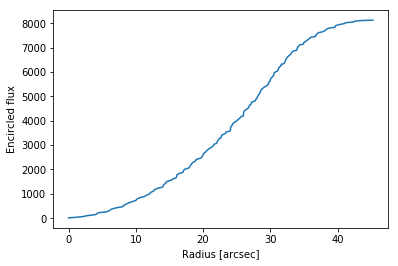

In [6]:
plt.plot(radii, encircled_flux)
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')

Looking at the shape of the encircled flux, it looks like the background level of our PSF is not zero. Let's check

In [7]:
# This is clearly. 
print(np.median(psf[0:5,:]))

7.80153393745


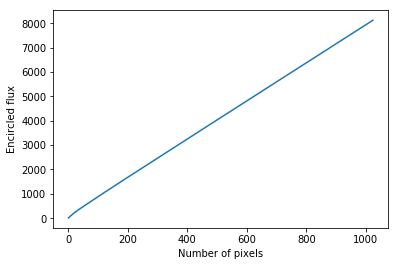

In [8]:
plt.plot(nbpix, encircled_flux)
plt.xlabel('Number of pixels')
plt.ylabel('Encircled flux')

In [9]:
# Lets do a linear fit to the outer part of the curve to determine the backgound
p = np.polyfit(nbpix[50:], encircled_flux[50:], 1)
bkg = p[0]

In [10]:
# Lets correct the psf and encircled flux
psf = psf - bkg
encircled_flux = encircled_flux - bkg * nbpix

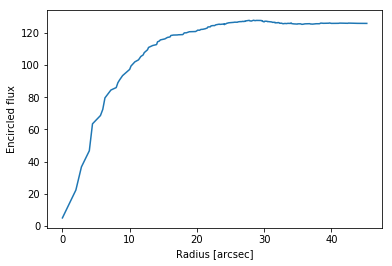

In [11]:
plt.plot(radii, encircled_flux)
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')

Our PSF does now behaves correctly.

Now let us compare our growth curve with the encircled energy curve provided by the instrument team. We use the standard growth curve for 100 µm PACS, taken with 20"/s scan speed. 

In [12]:
f = open('../data/PACS/EEF_grn_20.txt', 'r')
lines = f.readlines()
f.close()
radiuseff = np.zeros(len(lines)-3)
valeff = np.zeros(len(lines)-3)
i = 0
for line in lines:
    if line[0] != '#':
        bits = line.split()
        radiuseff[i] = float(bits[0])
        valeff[i] = float(bits[1])
        i = i+1

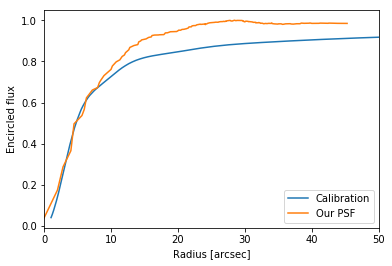

In [13]:
plt.plot(radiuseff, valeff, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 50])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

We will work below 30" where our PSF is well behaved

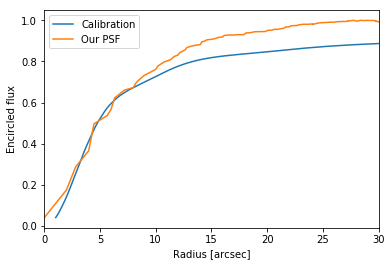

In [14]:
plt.plot(radiuseff, valeff, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 30])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

We see that while the calibration curve still rises beyond 30", our PSF has reached a plateau. Let's note the calibration $C(r)$. Our PSF encirled energy is of the form:

$E(r) = \alpha C(r \times \beta)$

Where $\beta$ is the fattening of the PSF.

We could take the derivative, but this too noisy. Instead we do a brute force approach

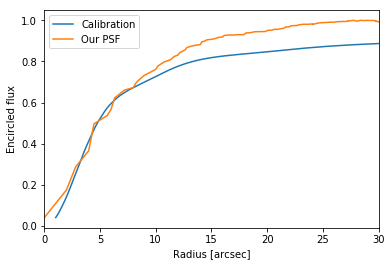

In [15]:
plt.plot(radiuseff, valeff, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 30])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

In [16]:
rfactor = np.arange(1.,2., 1e-3)
ffactor = np.arange(1.,2., 1e-3)
# work with the data points between 3 and 25"
idx, = np.where((radii > 2) & (radii < 25))
xv = radii[idx]
yv = encircled_flux[idx]/np.max(encircled_flux)
resid = np.zeros((len(rfactor), len(ffactor)))
for i, rf in enumerate(rfactor):
    print(i, rf)
    tck = interpolate.splrep(radiuseff*rf, valeff, s=0)
    yfit = interpolate.splev(xv, tck, der=0)
    for j, ff in enumerate(ffactor):
        resid[i, j] = np.sum((yv-yfit*ff)**2)


0 1.0
1 1.001
2 1.002
3 1.003
4 1.004
5 1.005
6 1.006
7 1.007
8 1.008
9 1.009
10 1.01
11 1.011
12 1.012
13 1.013
14 1.014
15 1.015
16 1.016
17 1.017
18 1.018
19 1.019
20 1.02
21 1.021
22 1.022
23 1.023
24 1.024
25 1.025
26 1.026
27 1.027
28 1.028
29 1.029
30 1.03
31 1.031
32 1.032
33 1.033
34 1.034
35 1.035
36 1.036
37 1.037
38 1.038
39 1.039
40 1.04
41 1.041
42 1.042
43 1.043
44 1.044
45 1.045
46 1.046
47 1.047
48 1.048
49 1.049
50 1.05
51 1.051
52 1.052
53 1.053
54 1.054
55 1.055
56 1.056
57 1.057
58 1.058
59 1.059
60 1.06
61 1.061
62 1.062
63 1.063
64 1.064
65 1.065
66 1.066
67 1.067
68 1.068
69 1.069
70 1.07
71 1.071
72 1.072
73 1.073
74 1.074
75 1.075
76 1.076
77 1.077
78 1.078
79 1.079
80 1.08
81 1.081
82 1.082
83 1.083
84 1.084
85 1.085
86 1.086
87 1.087
88 1.088
89 1.089
90 1.09
91 1.091
92 1.092
93 1.093
94 1.094
95 1.095
96 1.096
97 1.097
98 1.098
99 1.099
100 1.1
101 1.101
102 1.102
103 1.103
104 1.104
105 1.105
106 1.106
107 1.107
108 1.108
109 1.109
110 1.11
111 1.111
112 

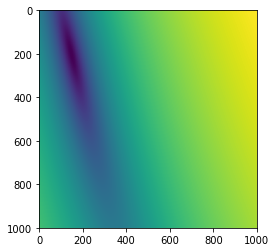

In [17]:
plt.imshow(np.log(resid))

This shows a minimum, with some degeneracy. 

In [18]:
imin = np.argmin(resid)
rmin, fmin = np.unravel_index(imin, resid.shape)
print("rf = {:.3f}, ff = {:.3f}, residual = {:.3f}".format(rfactor[rmin], ffactor[fmin], resid[rmin, fmin]))

rf = 1.199, ff = 1.148, residual = 0.023


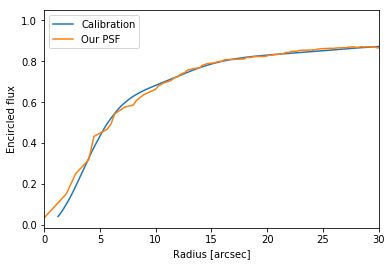

In [19]:
plt.plot(radiuseff*rfactor[rmin], valeff, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux)/ffactor[fmin], label='Our PSF')
plt.xlim([0, 30])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

In [20]:
# The two curve overlap
psfok = psf/np.max(encircled_flux)/ffactor[fmin]
np.sum(psfok)

0.85772075091428224

psfok is the PSF that a source of flux 1 Jy has in our data, and is to be used for source extraction